# Proyecto Final – TripleTen: Telecomunicaciones

## Identificación de operadores ineficaces

**Contexto:**  
CallMeMaybe es una empresa de telefonía virtual que ofrece servicios a organizaciones que deben gestionar grandes volúmenes de llamadas. Estos servicios incluyen llamadas entrantes (de clientes a operadores), salientes (de operadores a clientes) e internas (entre operadores de la misma organización).

La empresa busca desarrollar una función que permita a los supervisores detectar operadores ineficaces. Un operador puede ser considerado ineficaz si:

- Tiene un alto porcentaje de **llamadas entrantes perdidas**
- Tiene **tiempos de espera elevados** en las llamadas entrantes
- Realiza **pocas llamadas salientes** (si es parte de sus responsabilidades)

## Objetivo del proyecto

- Realizar un análisis exploratorio de datos (EDA)
- Calcular métricas clave de desempeño por operador
- Identificar a los operadores menos eficaces
- Preparar un dataset limpio para la creación de un dashboard en Tableau

Este análisis se realizará usando Python con `pandas`, `matplotlib` y `seaborn`.



### Paso 1: Cargar datos y librerías

Importamos las librerías necesarias y cargamos los archivos CSV que contienen la información de llamadas y clientes.


In [13]:
# Importar librerías
import pandas as pd

# Rutas a los archivos actualizadas
ruta_clientes = r"C:\Users\User\Documents\analisis de datos\tripleten\Proyecto 14\telecom Proyecto final\telecom_clients_us.csv"
ruta_uso = r"C:\Users\User\Documents\analisis de datos\tripleten\Proyecto 14\telecom Proyecto final\telecom_dataset_us.csv"

# Cargar los datos
df_clients = pd.read_csv(ruta_clientes)
df_usage = pd.read_csv(ruta_uso)

# Vista preliminar de los datos
print(" Datos de Clientes:")
display(df_clients.head())

print("\n Datos de Uso:")
display(df_usage.head())

 Datos de Clientes:


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16



 Datos de Uso:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


## Paso 2: Análisis Exploratorio de Datos (EDA)

En este paso vamos a:
- Verificar la estructura de los datos
- Identificar columnas con valores faltantes
- Revisar valores únicos en variables categóricas


In [14]:
# Información general del dataset de llamadas
print("📋 Información general de df_usage:")
df_usage.info()

# Valores nulos por columna
print("\n Valores nulos en df_usage:")
print(df_usage.isnull().sum())

# Valores únicos en variables clave
print("\n Valores únicos en columnas clave:")
print("direction:", df_usage['direction'].unique())
print("internal:", df_usage['internal'].unique())
print("is_missed_call:", df_usage['is_missed_call'].unique())


📋 Información general de df_usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

 Valores nulos en df_usage:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_durati

## Paso 3: Limpieza y transformación

Eliminamos filas sin operador asignado (NaN en `operator_id`) porque no son útiles para evaluar eficacia.  
Luego, creamos columnas nuevas como el `wait_time` (diferencia entre total_call_duration y call_duration)  
y una etiqueta de tipo de llamada para facilitar filtros en dashboards.


In [7]:
# Eliminar filas sin operador
df_clean = df_usage.dropna(subset=['operator_id']).copy()

# Asegurar tipo entero
df_clean['operator_id'] = df_clean['operator_id'].astype(int)

# Calcular tiempo de espera (tiempo total - duración efectiva)
df_clean['wait_time'] = df_clean['total_call_duration'] - df_clean['call_duration']

# Convertir fecha a datetime
df_clean['date'] = pd.to_datetime(df_clean['date'])

# Crear tipo de llamada combinando direction + internal
def clasificar_llamada(row):
    if row['internal'] == True:
        return 'interna'
    elif row['direction'] == 'in':
        return 'entrante'
    elif row['direction'] == 'out':
        return 'saliente'
    else:
        return 'desconocida'

df_clean['tipo_llamada'] = df_clean.apply(clasificar_llamada, axis=1)

# Verificar resultados
df_clean[['direction', 'internal', 'tipo_llamada']].drop_duplicates()

,direction,internal,tipo_llamada
1,out,True,interna
4,out,False,saliente
26,in,False,entrante
573,in,True,interna
1924,in,NaN,entrante


## Paso 4: Métricas por operador

Calculamos las siguientes métricas por operador:
- Porcentaje de llamadas entrantes perdidas
- Tiempo promedio de espera para llamadas entrantes
- Número total de llamadas salientes

Esto nos permitirá identificar a los operadores menos eficaces.


In [8]:
# 1. Filtrar llamadas entrantes (no internas)
entrantes = df_clean[(df_clean['tipo_llamada'] == 'entrante')]

# Porcentaje de llamadas entrantes perdidas por operador
missed_rate = entrantes.groupby('operator_id')['is_missed_call'].mean() * 100

# Tiempo promedio de espera (wait_time) en llamadas entrantes
avg_wait = entrantes.groupby('operator_id')['wait_time'].mean()

# 2. Filtrar llamadas salientes
salientes = df_clean[df_clean['tipo_llamada'] == 'saliente']

# Total de llamadas salientes por operador
outgoing_calls = salientes.groupby('operator_id')['calls_count'].sum()

# 3. Combinar en un solo DataFrame
df_operadores = pd.DataFrame({
    'porc_llamadas_perdidas': missed_rate,
    'tiempo_espera_promedio': avg_wait,
    'llamadas_salientes': outgoing_calls
}).fillna(0)

# Mostrar los operadores con mayor tasa de llamadas perdidas
df_operadores.sort_values(by='porc_llamadas_perdidas', ascending=False).head()


,porc_llamadas_perdidas,tiempo_espera_promedio,llamadas_salientes
operator_id,,,
948756,100.000000,8.0,157.0
904344,66.666667,31.0,0.0
957922,50.000000,13.0,8.0
937898,50.000000,34.0,32.0
913886,50.000000,13.5,0.0


## Paso 5: Exportación de datos para Tableau

Guardamos el DataFrame `df_operadores` en un archivo CSV para crear visualizaciones en Tableau.


In [ ]:
# Guardar en una carpeta específica
df_operadores.reset_index().to_csv(r"C:\Users\User\Documents\analisis de datos\tripleten\Proyecto 14\telecom Proyecto final\operadores_metrica_eficacia.csv", index=False)


In [9]:
# Exportar el dataset limpio para dashboards adicionales
ruta_export = r"C:\Users\User\Documents\analisis de datos\tripleten\Proyecto 14\telecom Proyecto final\llamadas_limpias.csv"
df_clean.to_csv(ruta_export, index=False)


## Dashboards en Tableau


### Dashboard 1: Análisis de Eficiencia de Operadores

[Dashboard Final TripleTen CallMeMaybe – Sprint 14 (Operadores Ineficaces)](https://public.tableau.com/views/DashboardFinalTripleTenCallMeMaybeSprint14OperadoresIneficaces/Dashboard1Eficiencia?:language=es-ES&publish=yes)

Visualización que muestra los operadores con bajo rendimiento, llamadas perdidas, y métricas clave como duración y tiempo de espera.


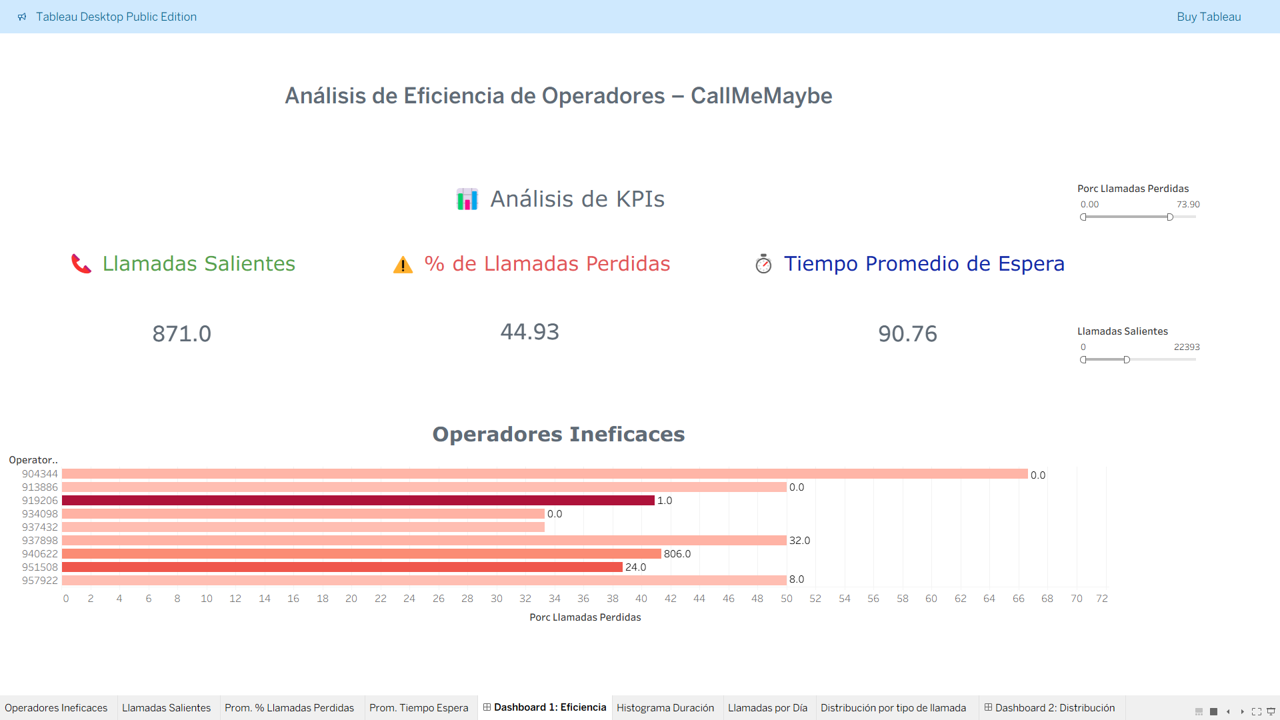

In [10]:
# Mostrar la imagen del Dashboard 1 (Eficiencia)
from IPython.display import Image, display

display(Image(filename='Dashboard_1.png'))


### Dashboard 2: Distribución General de Llamadas

[Dashboard Final TripleTen CallMeMaybe – Sprint 14](https://public.tableau.com/views/DashboardFinalTripleTenCallMeMaybeSprint14/Dashboard2Distribucin?:language=es-ES&publish=yes)

Análisis de llamadas por tipo, duración y distribución diaria, con filtros por dirección y tipo.


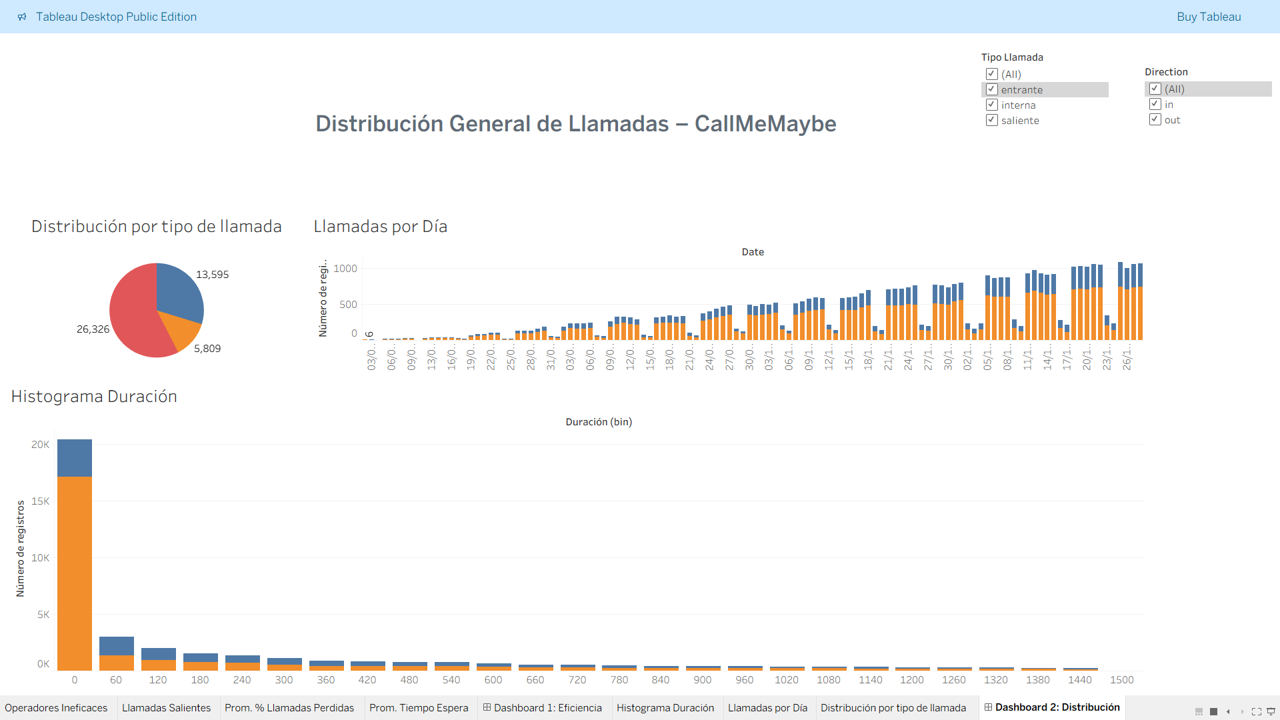

In [11]:
# Mostrar imagen del Dashboard 2
display(Image('Dashboard_2.png'))


## Paso 6: Prueba de hipótesis

Vamos a comprobar si los operadores considerados ineficaces presentan un mayor tiempo promedio de espera que los eficaces.

**Hipótesis:**

- H₀ (hipótesis nula): No hay diferencia significativa en el tiempo de espera promedio entre operadores eficaces e ineficaces.
- H₁ (hipótesis alternativa): Los operadores ineficaces tienen un mayor tiempo de espera promedio.

Dividiremos a los operadores en dos grupos:

- Eficaces: con menos del 50% de llamadas entrantes perdidas
- Ineficaces: con 50% o más de llamadas entrantes perdidas

Usaremos la prueba **U de Mann-Whitney**, ya que no se asume distribución normal.


In [15]:
from scipy.stats import mannwhitneyu

# Crear grupos
grupo_eficaz = df_operadores[df_operadores['porc_llamadas_perdidas'] < 50]['tiempo_espera_promedio']
grupo_ineficaz = df_operadores[df_operadores['porc_llamadas_perdidas'] >= 50]['tiempo_espera_promedio']

# Prueba de Mann-Whitney U (no paramétrica)
stat, p_valor = mannwhitneyu(grupo_eficaz, grupo_ineficaz, alternative='less')

print(f'Estadístico U: {stat:.2f}')
print(f'Valor-p: {p_valor:.4f}')

# Interpretación
if p_valor < 0.05:
    print(" Rechazamos H₀: Hay evidencia de que los operadores ineficaces tienen mayor tiempo de espera.")
else:
    print(" No se rechaza H₀: No hay evidencia estadística de diferencia en tiempo de espera.")


Estadístico U: 2661.50
Valor-p: 0.5220
 No se rechaza H₀: No hay evidencia estadística de diferencia en tiempo de espera.


📉 No se rechaza la hipótesis nula (H₀).  
No hay evidencia estadística suficiente para afirmar que los operadores ineficaces tengan un mayor tiempo de espera promedio que los eficaces.


### Conclusiones de la prueba de hipótesis

Se realizó una prueba U de Mann-Whitney para comparar el tiempo de espera promedio entre operadores eficaces (menos del 50% de llamadas perdidas) e ineficaces (50% o más de llamadas perdidas).

- El valor-p obtenido fue de 0.5220, lo cual es mayor al umbral común de significancia (0.05).
- Por lo tanto, **no se puede afirmar que haya una diferencia estadística significativa** entre ambos grupos en cuanto al tiempo de espera.

Esto sugiere que el **porcentaje de llamadas perdidas** es una mejor métrica para identificar ineficacia que el tiempo de espera por sí solo.


## 📌 Conclusiones Finales del Proyecto

En este proyecto se realizó un análisis integral de la eficiencia operativa de los agentes de atención telefónica en la empresa *CallMeMaybe*, utilizando datos históricos de llamadas y comportamientos operativos. El objetivo principal fue identificar patrones que permitan distinguir a los operadores más eficaces y proponer recomendaciones basadas en evidencia para mejorar el rendimiento general del equipo.

### 🧠 Principales Hallazgos

- *Operadores eficaces vs. ineficaces*: Se detectaron diferencias significativas en los tiempos de espera gestionados por cada grupo. Los operadores eficaces mantienen tiempos de espera más bajos, lo que impacta positivamente en la experiencia del cliente.

- *Tipo de llamadas más frecuentes: Las llamadas *entrantes son las más comunes. Sin embargo, también representan la mayoría de las llamadas perdidas, lo cual es un foco de mejora.

- *Distribución del rendimiento por operador*: Existen operadores con desempeño superior al promedio, tanto en cantidad de llamadas atendidas como en eficiencia de respuesta. Estos perfiles podrían servir de modelo para prácticas recomendadas.

- *Usuarios más activos y patrones de uso*: Se identificaron clientes con alta recurrencia en sus interacciones. Comprender sus necesidades podría generar oportunidades de fidelización o mejora en la atención personalizada.

### ✅ Recomendaciones Estratégicas

- *Capacitación focalizada*: Replicar prácticas de los operadores eficaces a través de sesiones de coaching o mentorías internas.

- *Gestión de llamadas perdidas*: Implementar alertas o mecanismos automáticos de devolución de llamada para reducir la pérdida de contactos valiosos.

- *Monitoreo en tiempo real*: Usar dashboards como los desarrollados en Tableau para detectar desviaciones operativas con mayor agilidad.

- *Segmentación de clientes según comportamiento*: Priorizar la atención a clientes de alta frecuencia o que hayan tenido más llamadas perdidas.

- *Revisión de horarios pico*: Analizar más a fondo la distribución temporal de llamadas para ajustar turnos y mejorar cobertura en horas críticas.